In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import geopandas
import datetime as dt
import geopy

style.use('fivethirtyeight')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
def get_year_month_list(start_month, start_year, end_month, end_year):
    year_month_list = []
    ym_start= 12*start_year + start_month - 1
    ym_end= 12*end_year + end_month 
    for ym in range( ym_start, ym_end ):
        y, m = divmod( ym, 12 )
        y = str(y)[2:]
        m = '{0:02d}'.format(m+1)
        year_month_list += [y+m]
    return year_month_list

def get_all_local_citi_df(start_month=4, start_year=2016, 
                          end_month=4, end_year=2021):
    
    year_month_list = get_year_month_list(start_month, start_year, 
                                          end_month, end_year)
    citis = list()

    for year_month in year_month_list:
        citi = pd.read_parquet(f'https://s3.amazonaws.com/ctbk/20{year_month}-citibike-tripdata.parquet')
        citis.append(citi)
    citi_all = pd.concat(citis, axis=0, ignore_index=True)
    return citi_all

citi = get_all_local_citi_df(start_month=5, start_year=2020)


station_zipcode1 = pd.read_csv(r'station_zipcode.csv',
                   index_col=0,
                              )
zipcode_dict = dict(zip(station_zipcode1.station_id, station_zipcode1.zipcode))

def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    try:
        return location.raw['address']['postcode']
    except KeyError:
        return 'XXXXXXXXX'

def update_zip_code_dict(citi_, id_to_zipcode_={}):
    print('updatezipcode dict')
    current_id_to_zipcode = list(id_to_zipcode_.keys())
    citi_ = citi_[~citi_['End Station ID'].isin(current_id_to_zipcode)]
    citi_zip = citi_.drop_duplicates(subset=['End Station ID'])[['End Station ID',
                                                                    'End Station Latitude',
                                                                    'End Station Longitude']]
    try:
        print('get zipcode')
        geolocator = geopy.Nominatim(user_agent='testing_for_citi_bike')
        citi_zip['zipcodes'] = citi_zip.apply(get_zipcode, axis=1, geolocator=geolocator, 
                                            lat_field='End Station Latitude', 
                                            lon_field='End Station Longitude')
        
        id_to_zipcode_.update(dict(zip(citi_zip['End Station ID'], 
                                      citi_zip['zipcodes'])))
    except ValueError:
        print('No new ZIP codes.')
    return id_to_zipcode_


id_to_zipcode = update_zip_code_dict(citi,zipcode_dict)

id_to_zipcode.update({150:'10009',
                      151:'10012',
                      216:'11201',
                      217:'11201',
                      250:'10012',
                      252:'10011',
                      265:'10002',
                      298:'11217',
                      367:'10022',
                      386:'10013',
                      387:'10007',
                      391:'11201',
                      392:'11201',
                      400:'10002',
                      422:'10023',
                      434:'10011',
                      455:'10017',
                      473:'10002',
                      479:'10036',
                      501:'10016',
                      509:'10011',
                      514:'10018',
                      516:'10017',
                      530:'10069',
                      536:'10016',
                      3137:'10021',
                      3141:'10065',
                      3158:'10023',
                      3160:'10024',
                      3163:'10023',
                      3292:'10029',
                      3299:'10029',
                      3309:'10029',
                      3336:'10029',
                      3341:'10025',
                      3342:'11231',
                      3343:'10025',
                      3366:'10025',    
                      3383:'10025',
                      3394:'11231',
                      3443:'10104',
                      3472:'10011',
                      3541:'10027',
                      3676:'11231',
                      3686:'10014',
                      3744:'10003',
                      3746:'10013',
                      3809:'10019',
                      3921:'10454',
                      3924:'10451',
                      3942:'10027',
                      3983:'10455',
                      4045:'10069',
                      4073:'10019',    
                      4090:'10451',
                      4113:'10035',
                      4115:'10035',
                      4121:'10016',
                      4136:'10451',
                      3263:'10003',
                      4478:'10003'  
                      })

citi["start_zipcode"] = citi["Start Station ID"].map(id_to_zipcode)
citi["end_zipcode"] = citi["End Station ID"].map(id_to_zipcode)

id_to_zipcode_df = pd.DataFrame(id_to_zipcode.items(), columns=['station_id', 'zipcode'])
id_to_zipcode_df.to_csv('station_zipcode.csv')


updatezipcode dict
get zipcode
No new ZIP codes.


In [5]:
citi = citi[['Trip Duration', 'Start Time', 
                           'Start Station Name', 'Start Station Latitude',
                           'Start Station Longitude', 'End Station Name',
                           'End Station Latitude', 'End Station Longitude', 
                           'start_zipcode', 'end_zipcode']]
trip_duration_extreme = citi["Trip Duration"].quantile(0.99)
citi = citi[(citi["Trip Duration"] < trip_duration_extreme)]


nyc_zip_df = geopandas.read_file("ZIP_CODE_040114.shp")  
nyc_zip_list = list(nyc_zip_df.ZIPCODE)
# removing all possible non-essential rows/ columns to make it more usable.
citi = citi[citi['start_zipcode'].isin(nyc_zip_list)]
citi = citi[citi['end_zipcode'].isin(nyc_zip_list)]


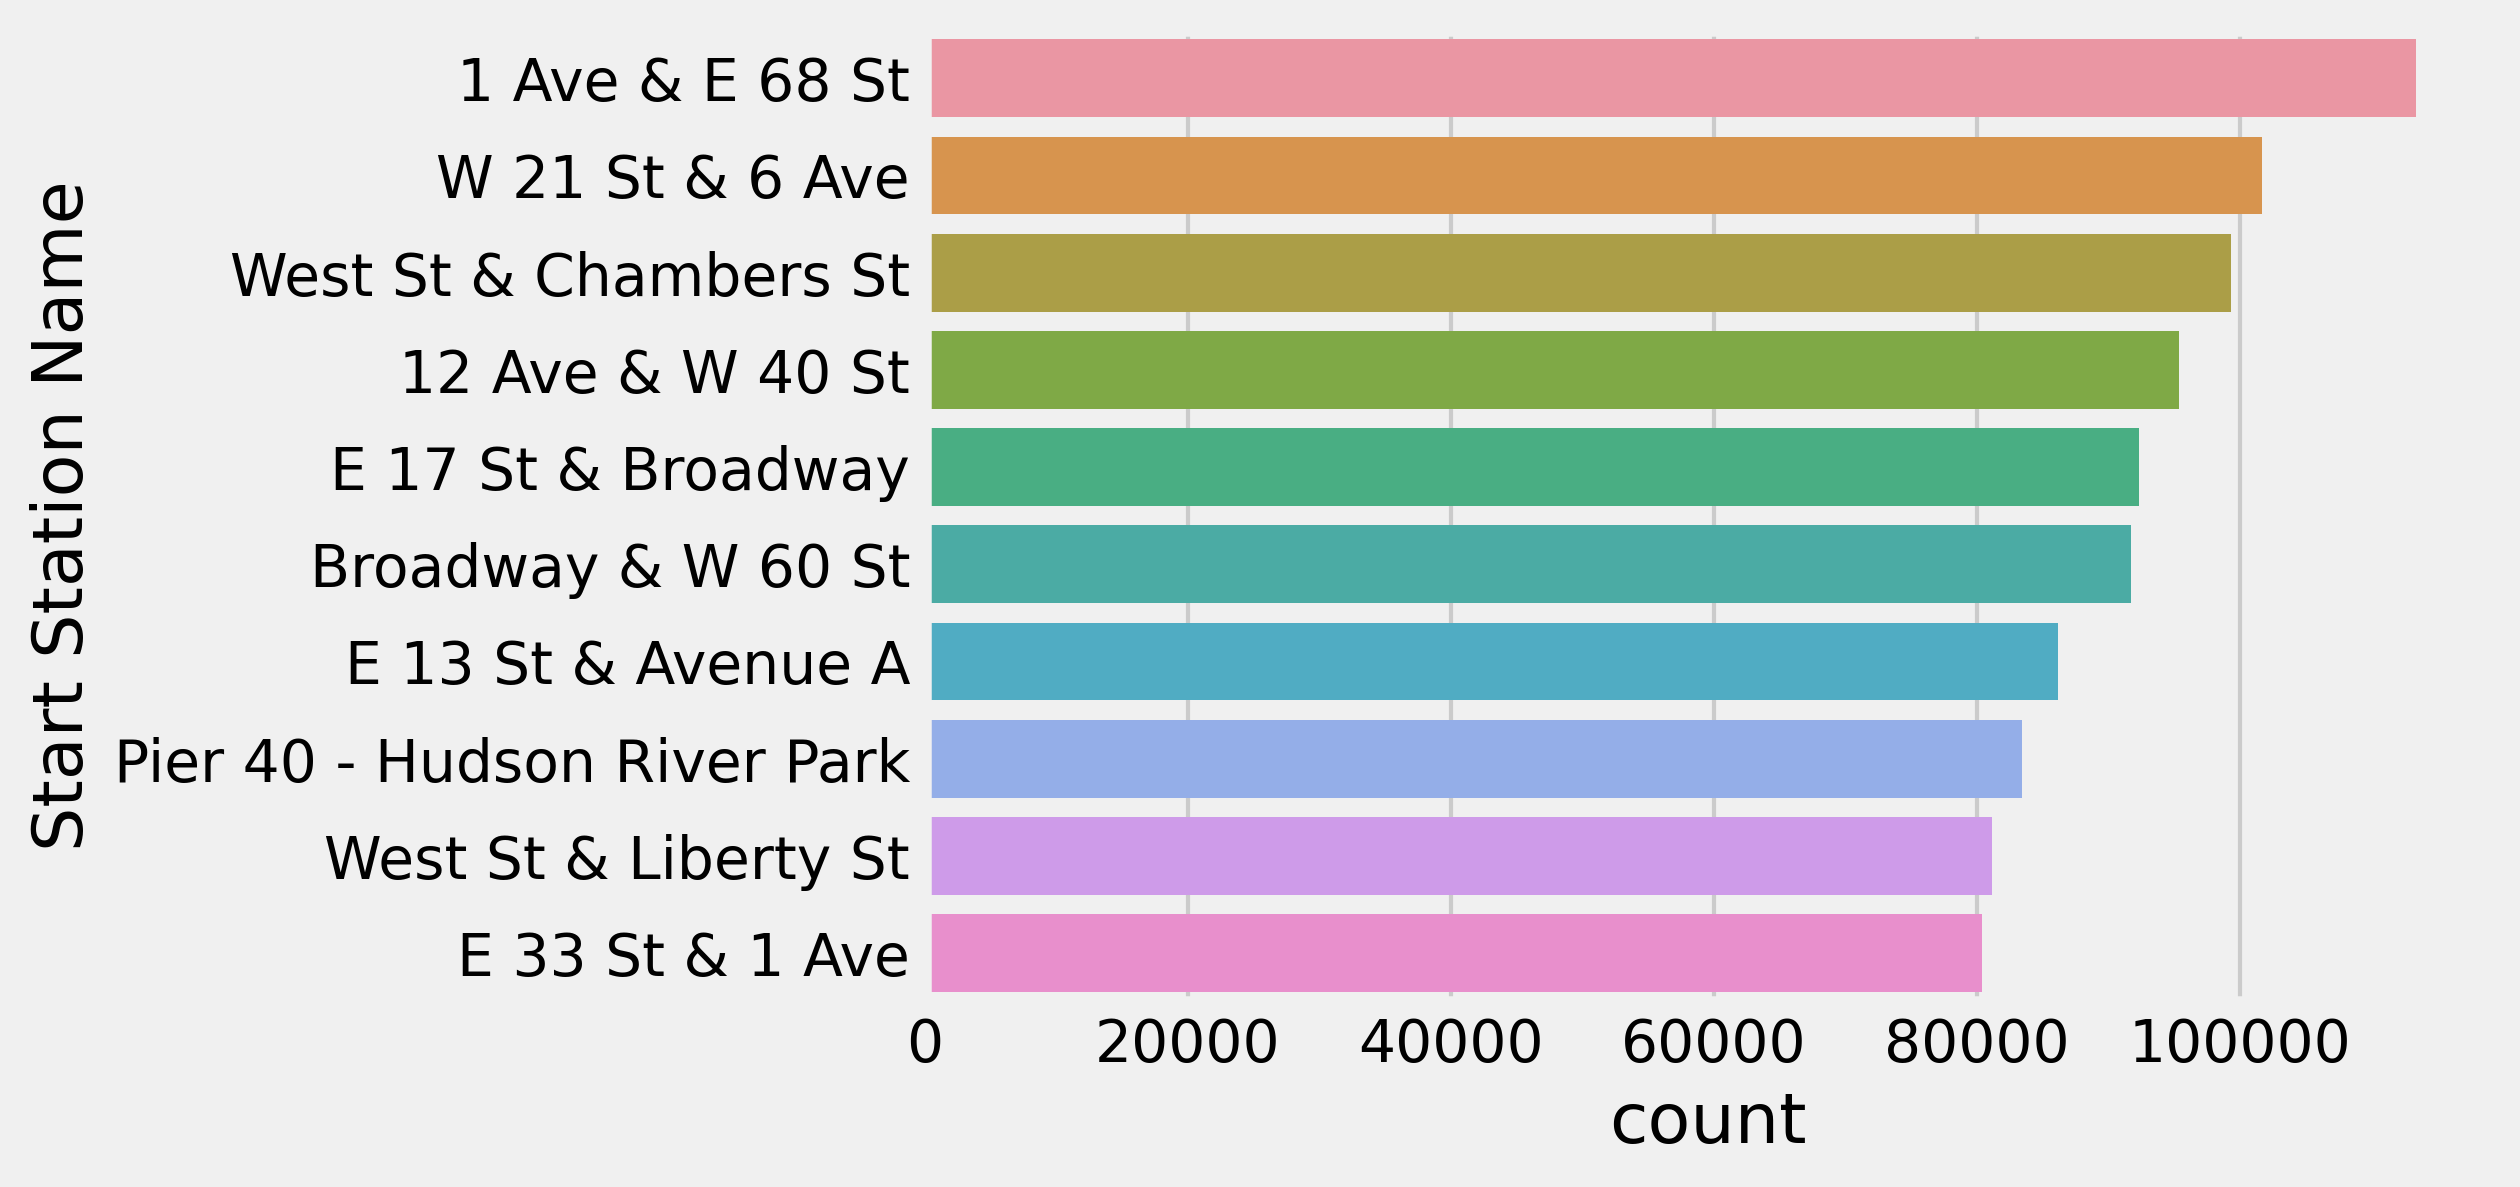

In [7]:
g = sns.countplot(y="Start Station Name", 
                  data=citi,
                  order = citi['Start Station Name'].value_counts().iloc[:10].index)



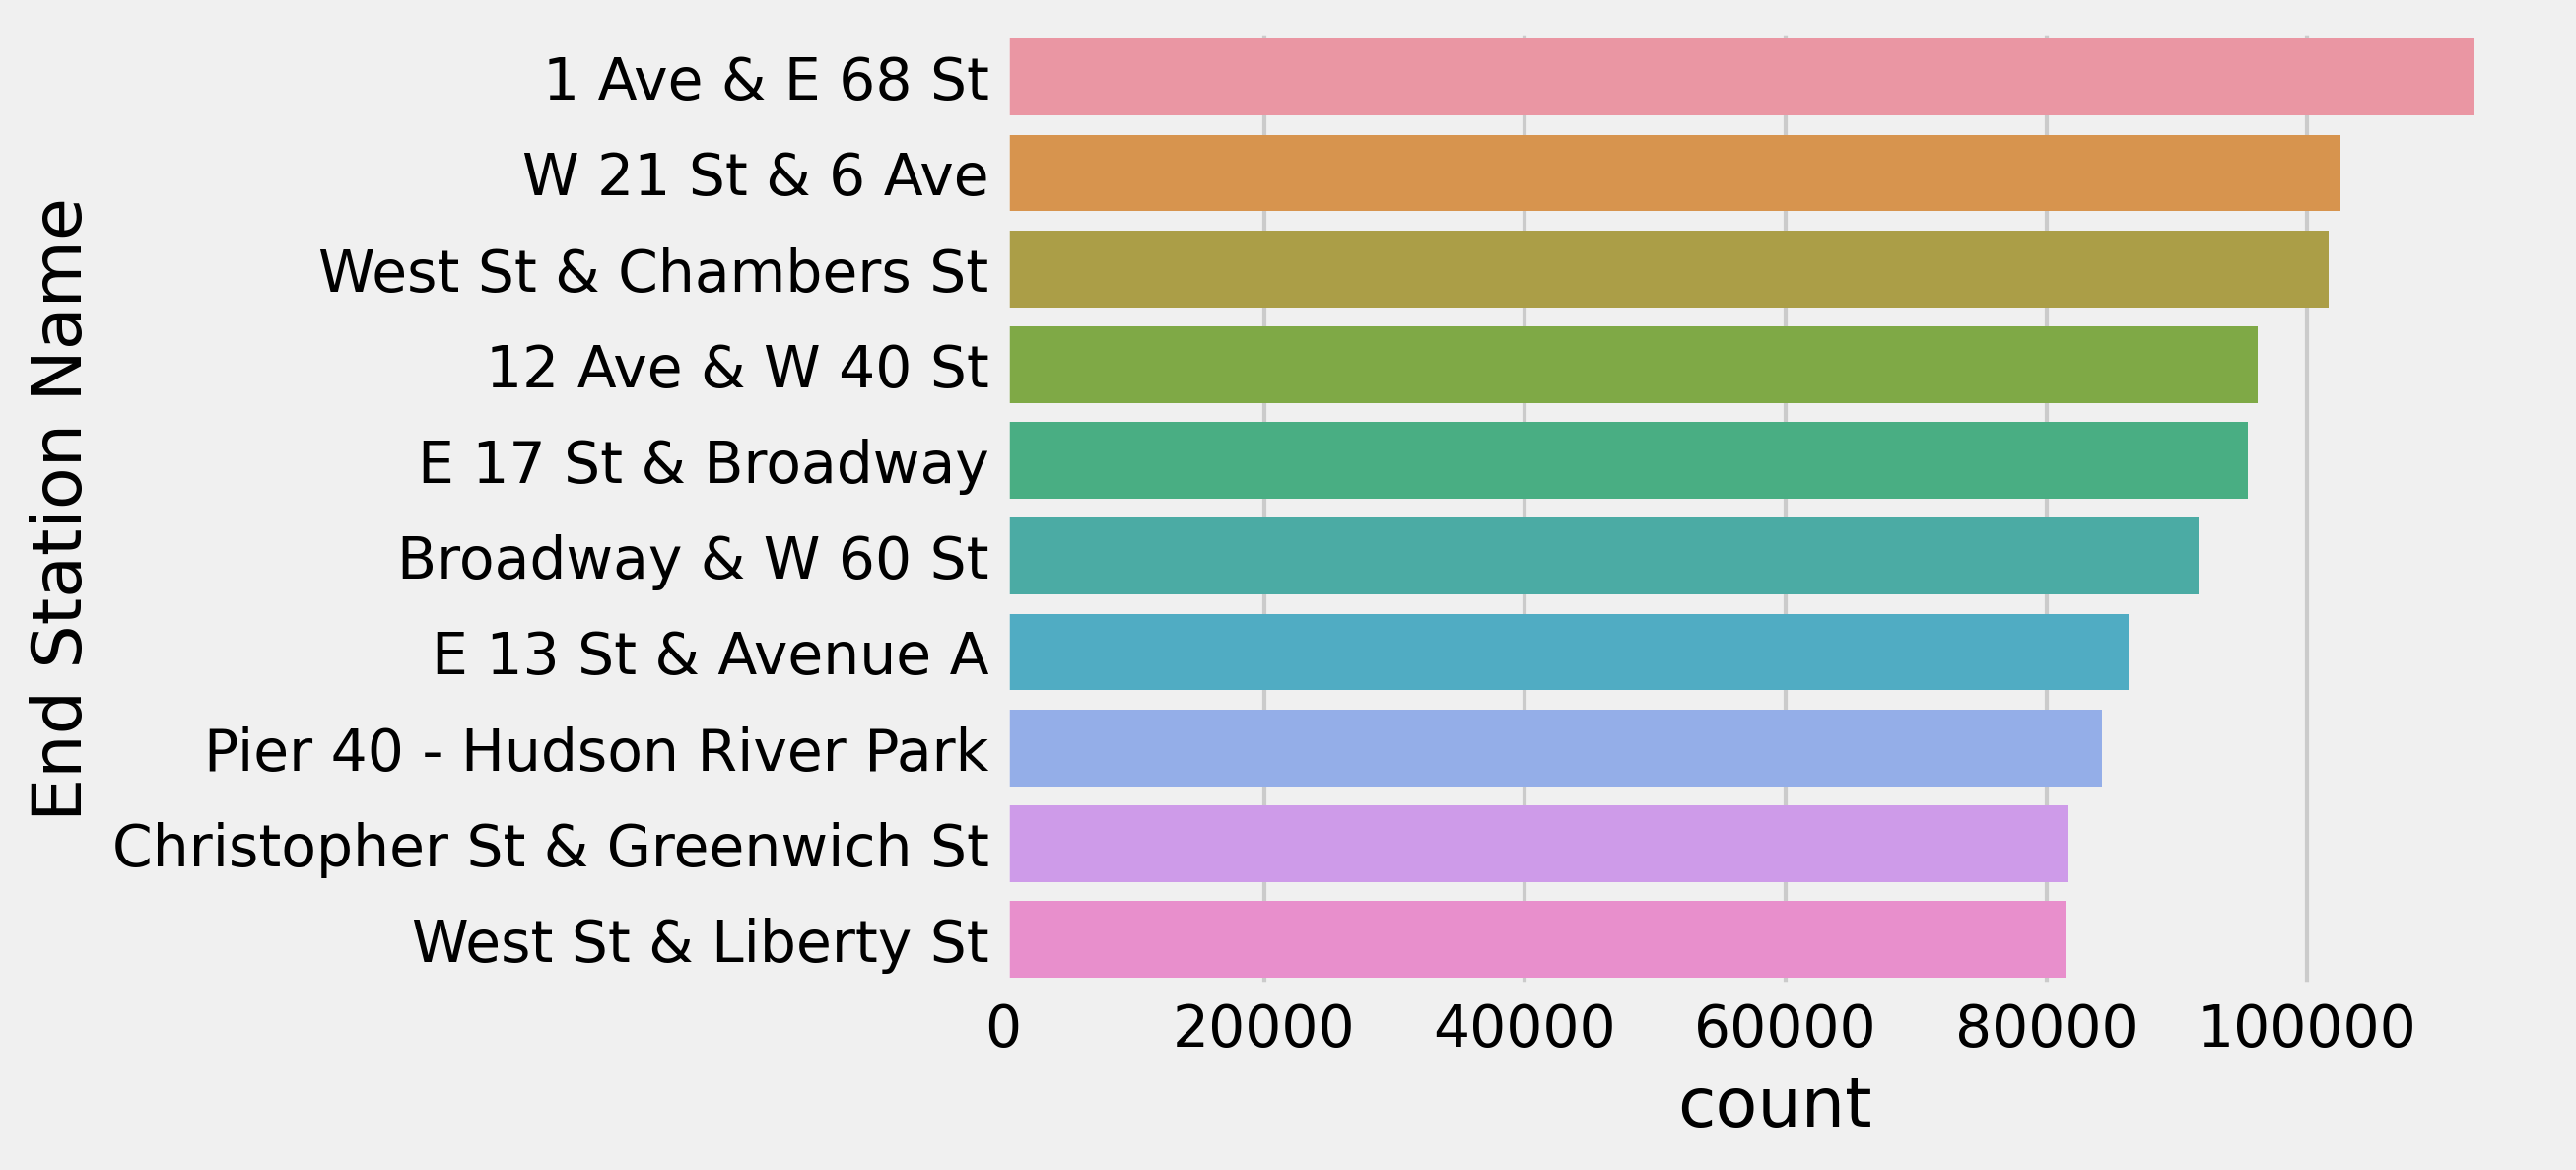

In [8]:
g = sns.countplot(y="End Station Name", 
                  data=citi,
                  order = citi['End Station Name'].value_counts().iloc[:10].index)


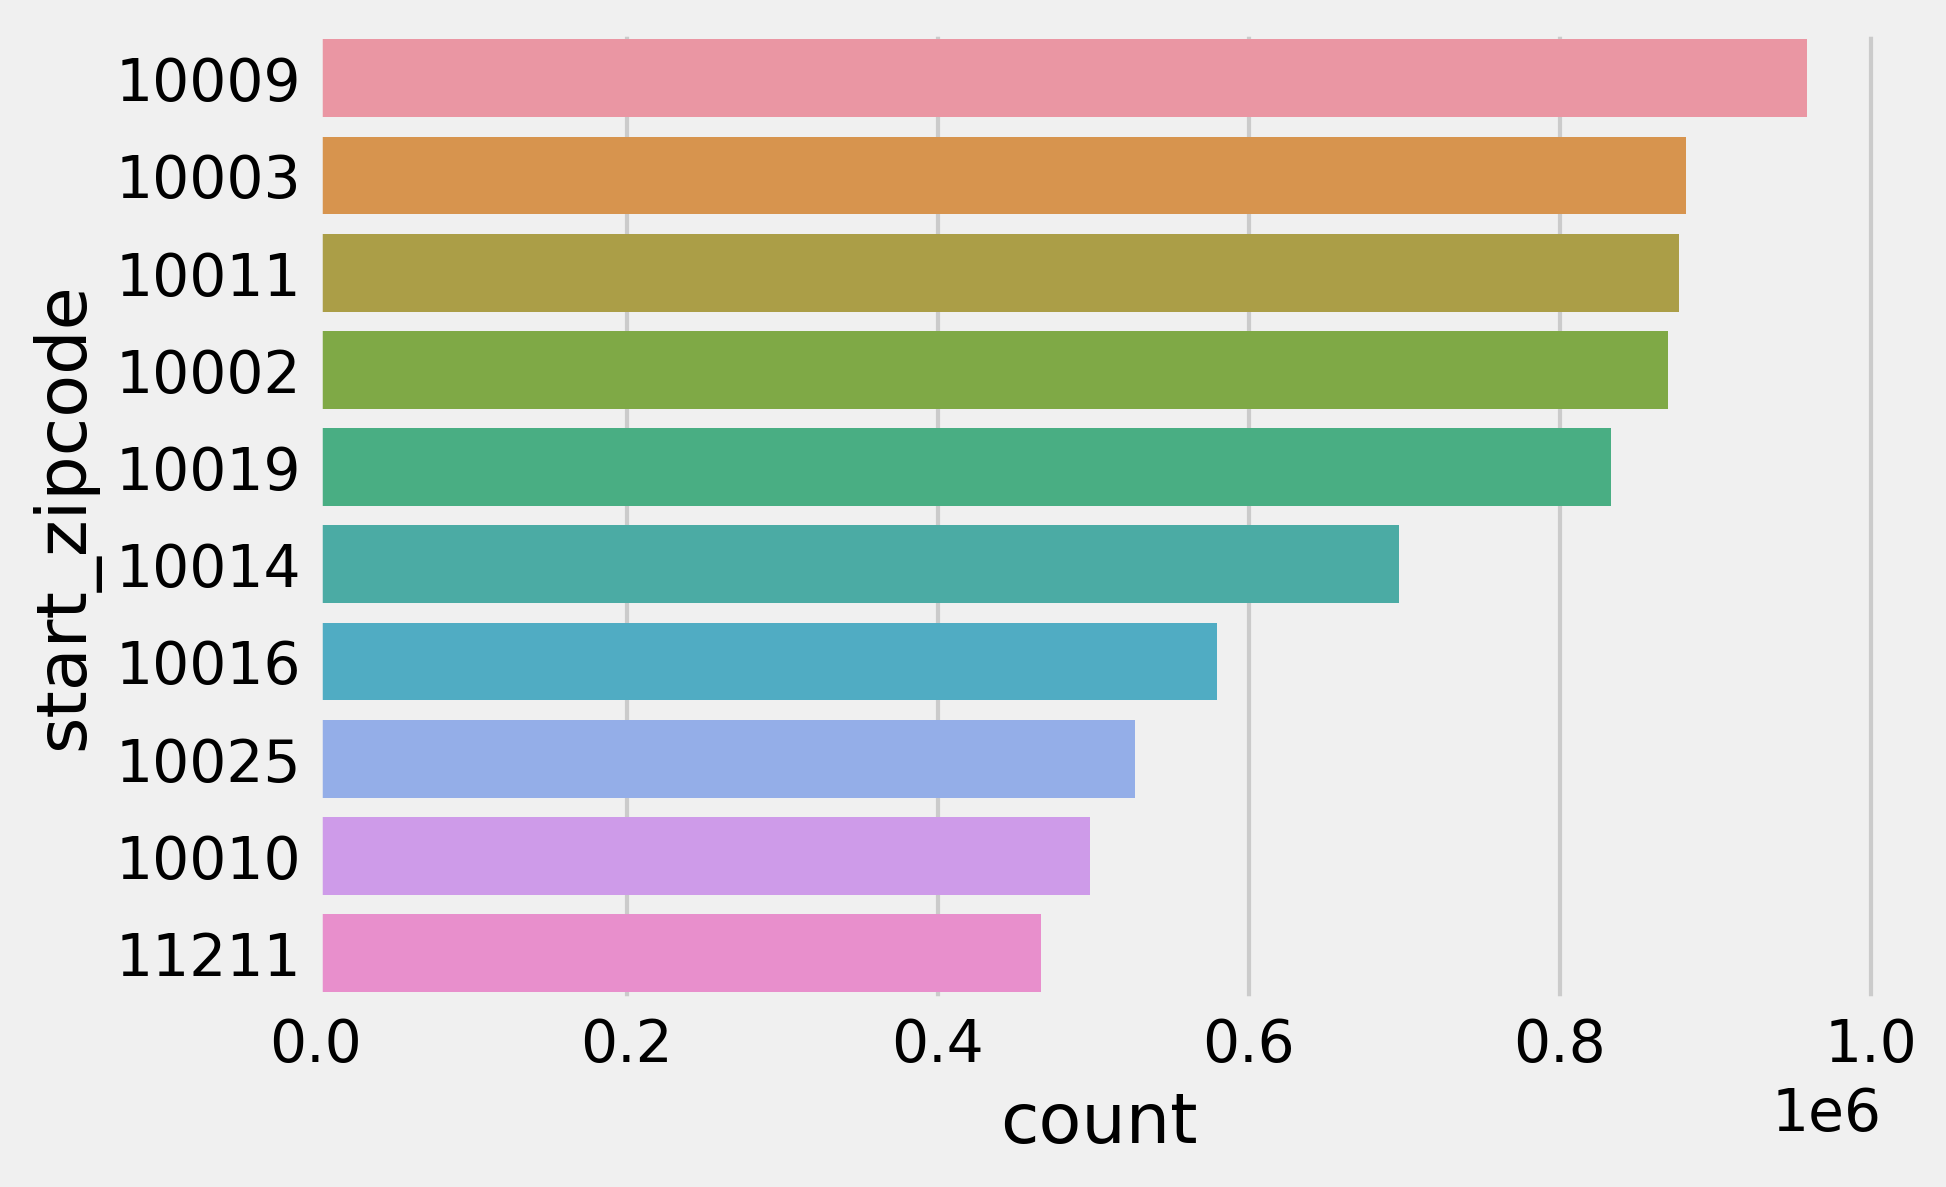

In [9]:
g = sns.countplot(y="start_zipcode", 
                  data=citi,
                  order = citi['start_zipcode'].value_counts().iloc[:10].index)


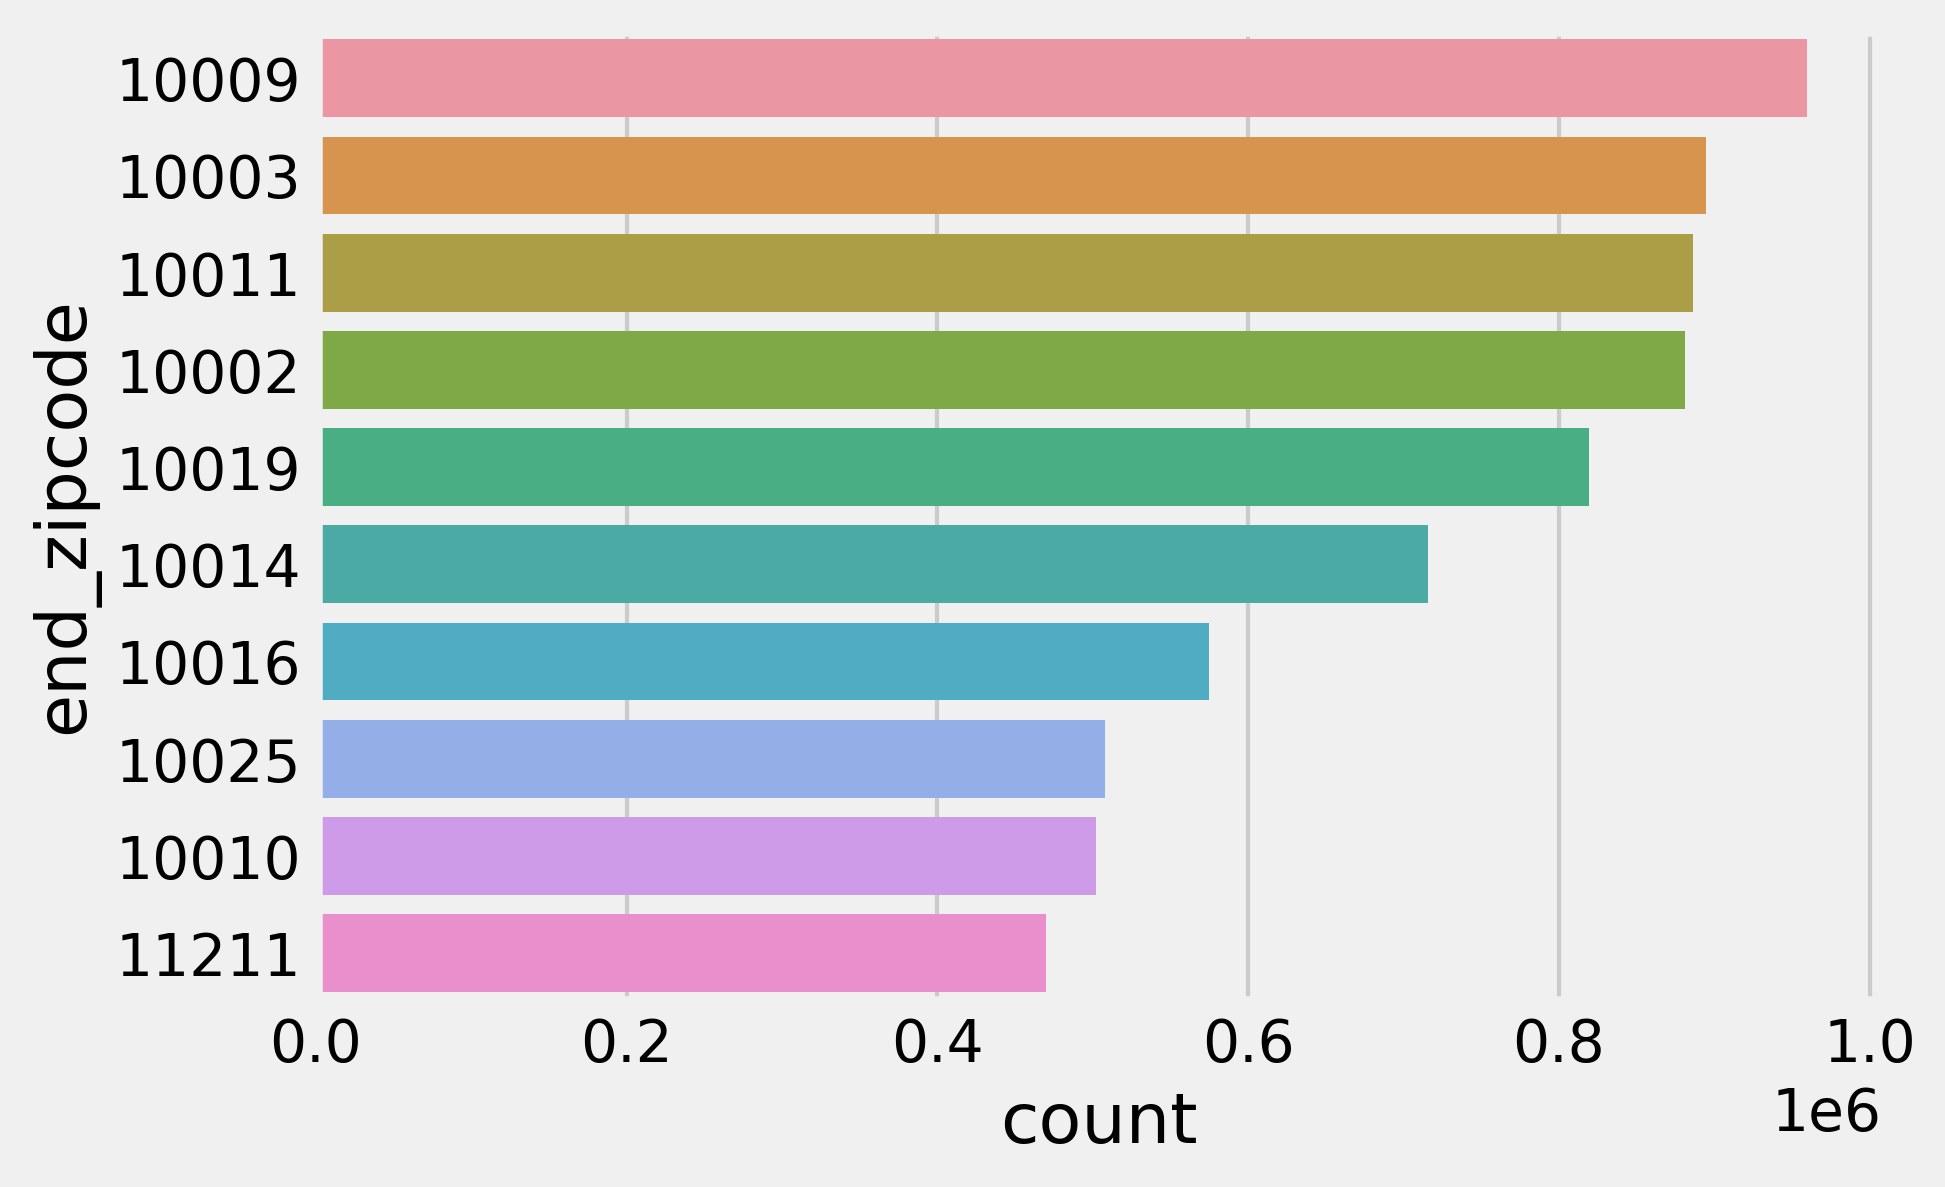

In [10]:
g = sns.countplot(y="end_zipcode", 
                  data=citi,
                  order = citi['end_zipcode'].value_counts().iloc[:10].index)



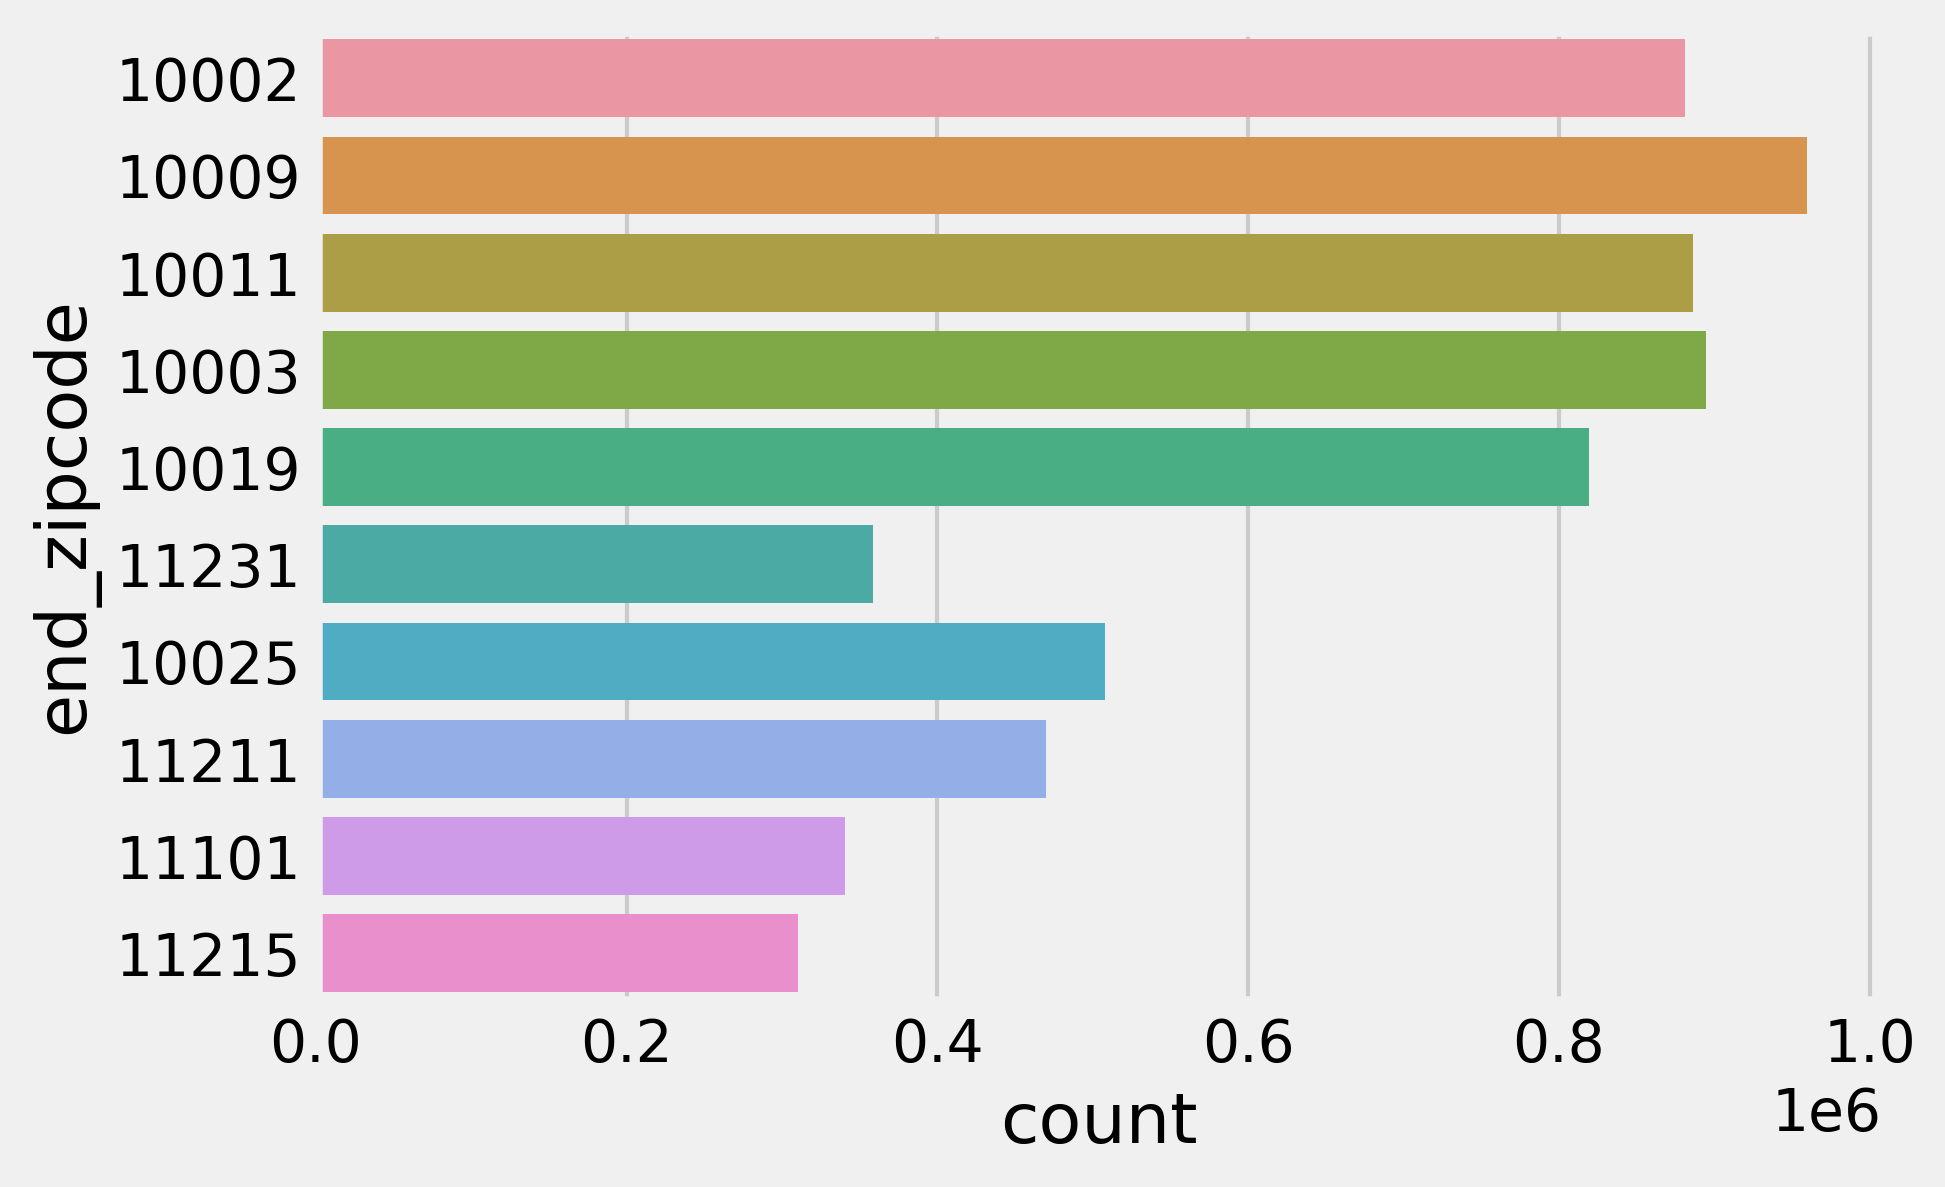

In [11]:
g = sns.countplot(y="end_zipcode", 
                  data=citi,
                  order = citi[citi['end_zipcode']==citi['start_zipcode']]['end_zipcode'].value_counts().iloc[:10].index)



In [14]:
thing = citi['end_zipcode'].value_counts().iloc[:10].reset_index()
new_thing2 = nyc_zip_df.merge(thing, right_on='index' ,left_on='ZIPCODE')




In [15]:
color = ['#fff100',
         '#ff8c00',
         '#e81123',
         '#ec008c',
         '#68217a',
         '#00188f',
         '#00bcf2',
         '#00b294',
         '#009e49',
         '#bad80a']  
zips_code = list(citi['end_zipcode'].value_counts().iloc[:10].index)
color_mapping = dict(zip(zips_code,color))


# new_thing2.plot(color=new_thing2["ZIPCODE"].map(color_mapping))
fig,axs = plt.subplots(2,figsize = (30, 30))

zip_boundry_map = nyc_zip_df.boundary.plot(color='Black', linewidth=.5,ax=axs[1])
new_thing2.plot(color=new_thing2["ZIPCODE"].map(color_mapping),ax=zip_boundry_map)
# gstart_stations.plot(color='red', markersize = 10,ax=zip_boundry_map)
# zip_boundry_map.axis('off')


minx, miny, maxx, maxy = new_thing2.total_bounds
axs[1].set_xlim(minx, maxx)
axs[1].set_ylim(miny, maxy)

g = sns.countplot(y="end_zipcode", 
                  data=citi,
                  order = citi['end_zipcode'].value_counts().iloc[:10].index,
                  palette=color,
                  ax=axs[0]
                  )



20390436

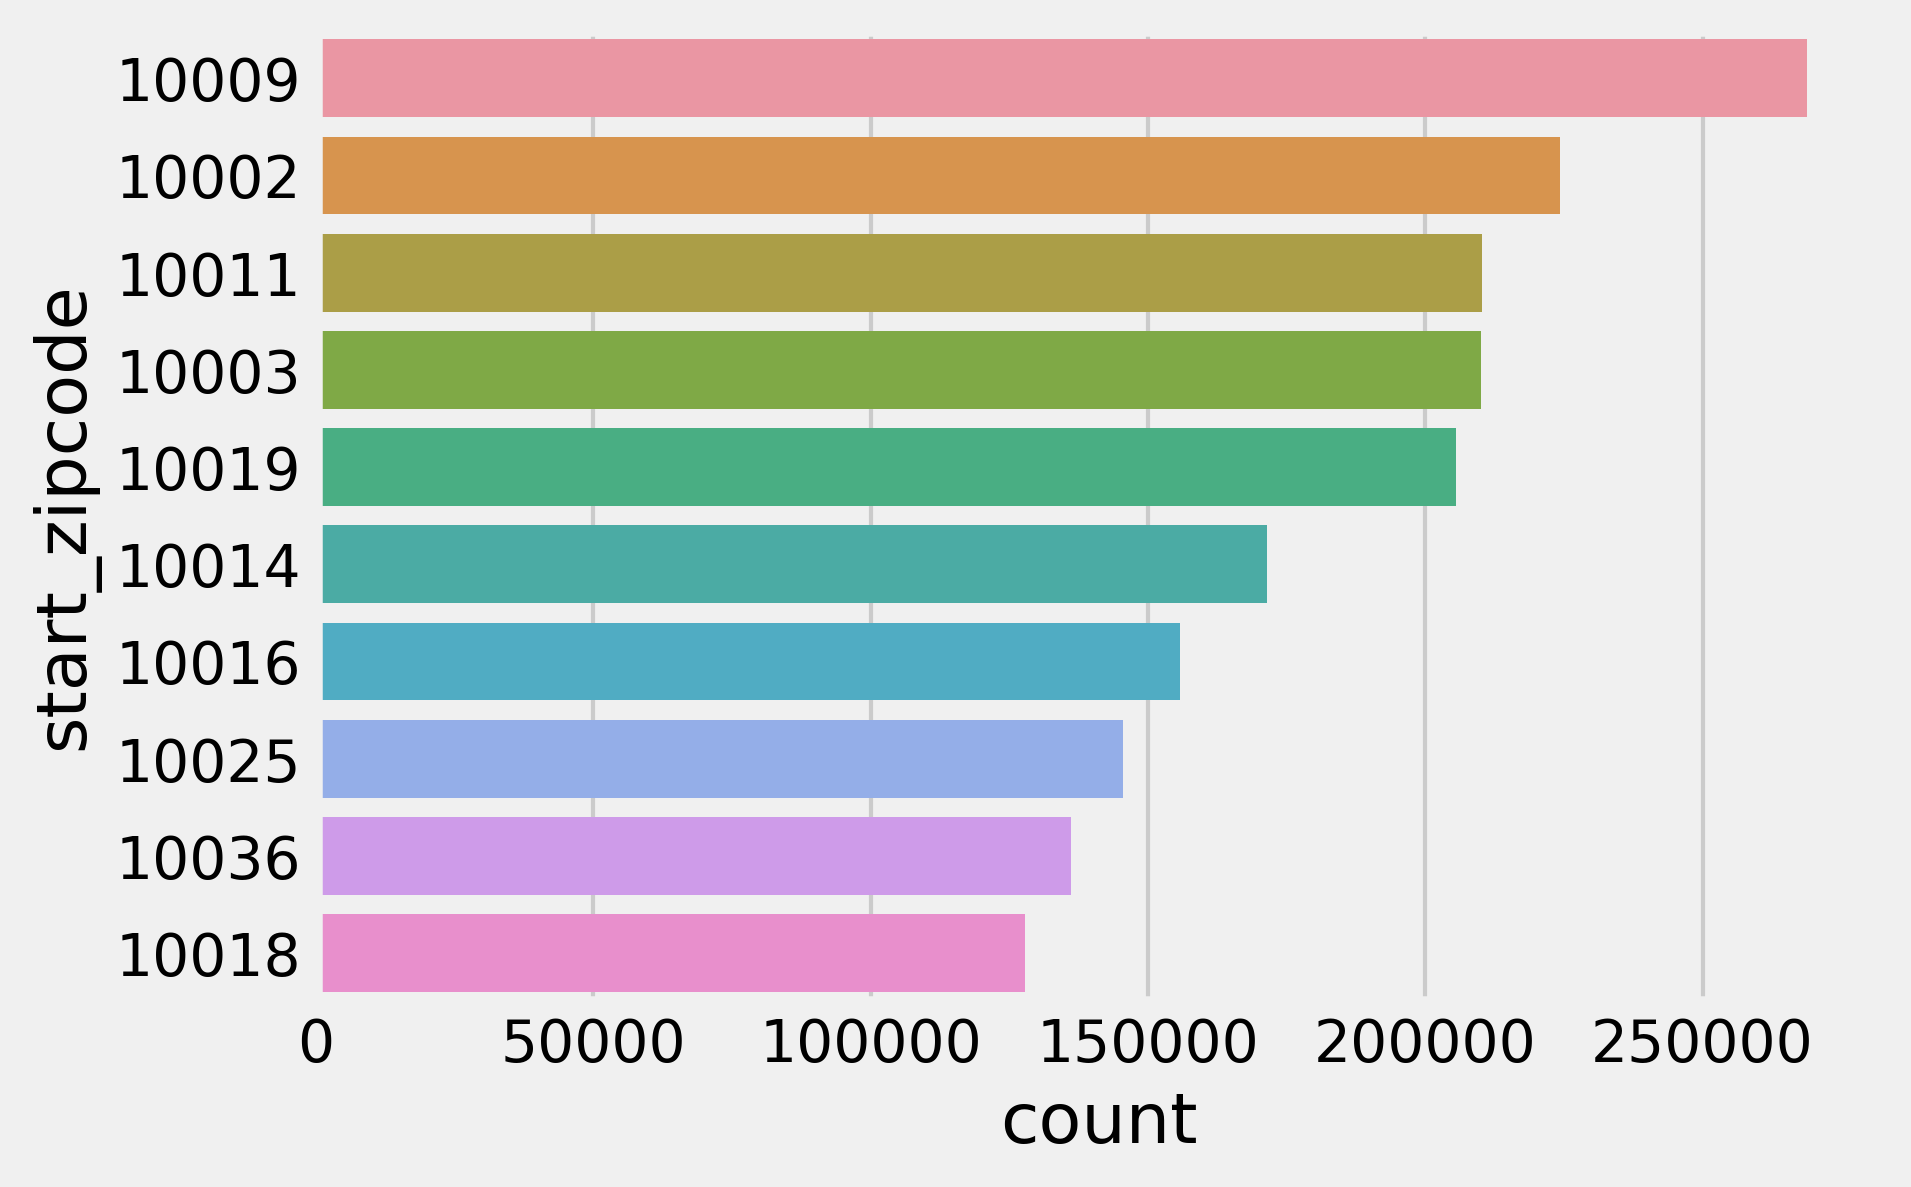

In [22]:
pre_noon = citi[citi['Start Time'].dt.hour<12]
g = sns.countplot(y="start_zipcode", 
                  data=pre_noon,
                  order = pre_noon['start_zipcode'].value_counts().iloc[:10].index)



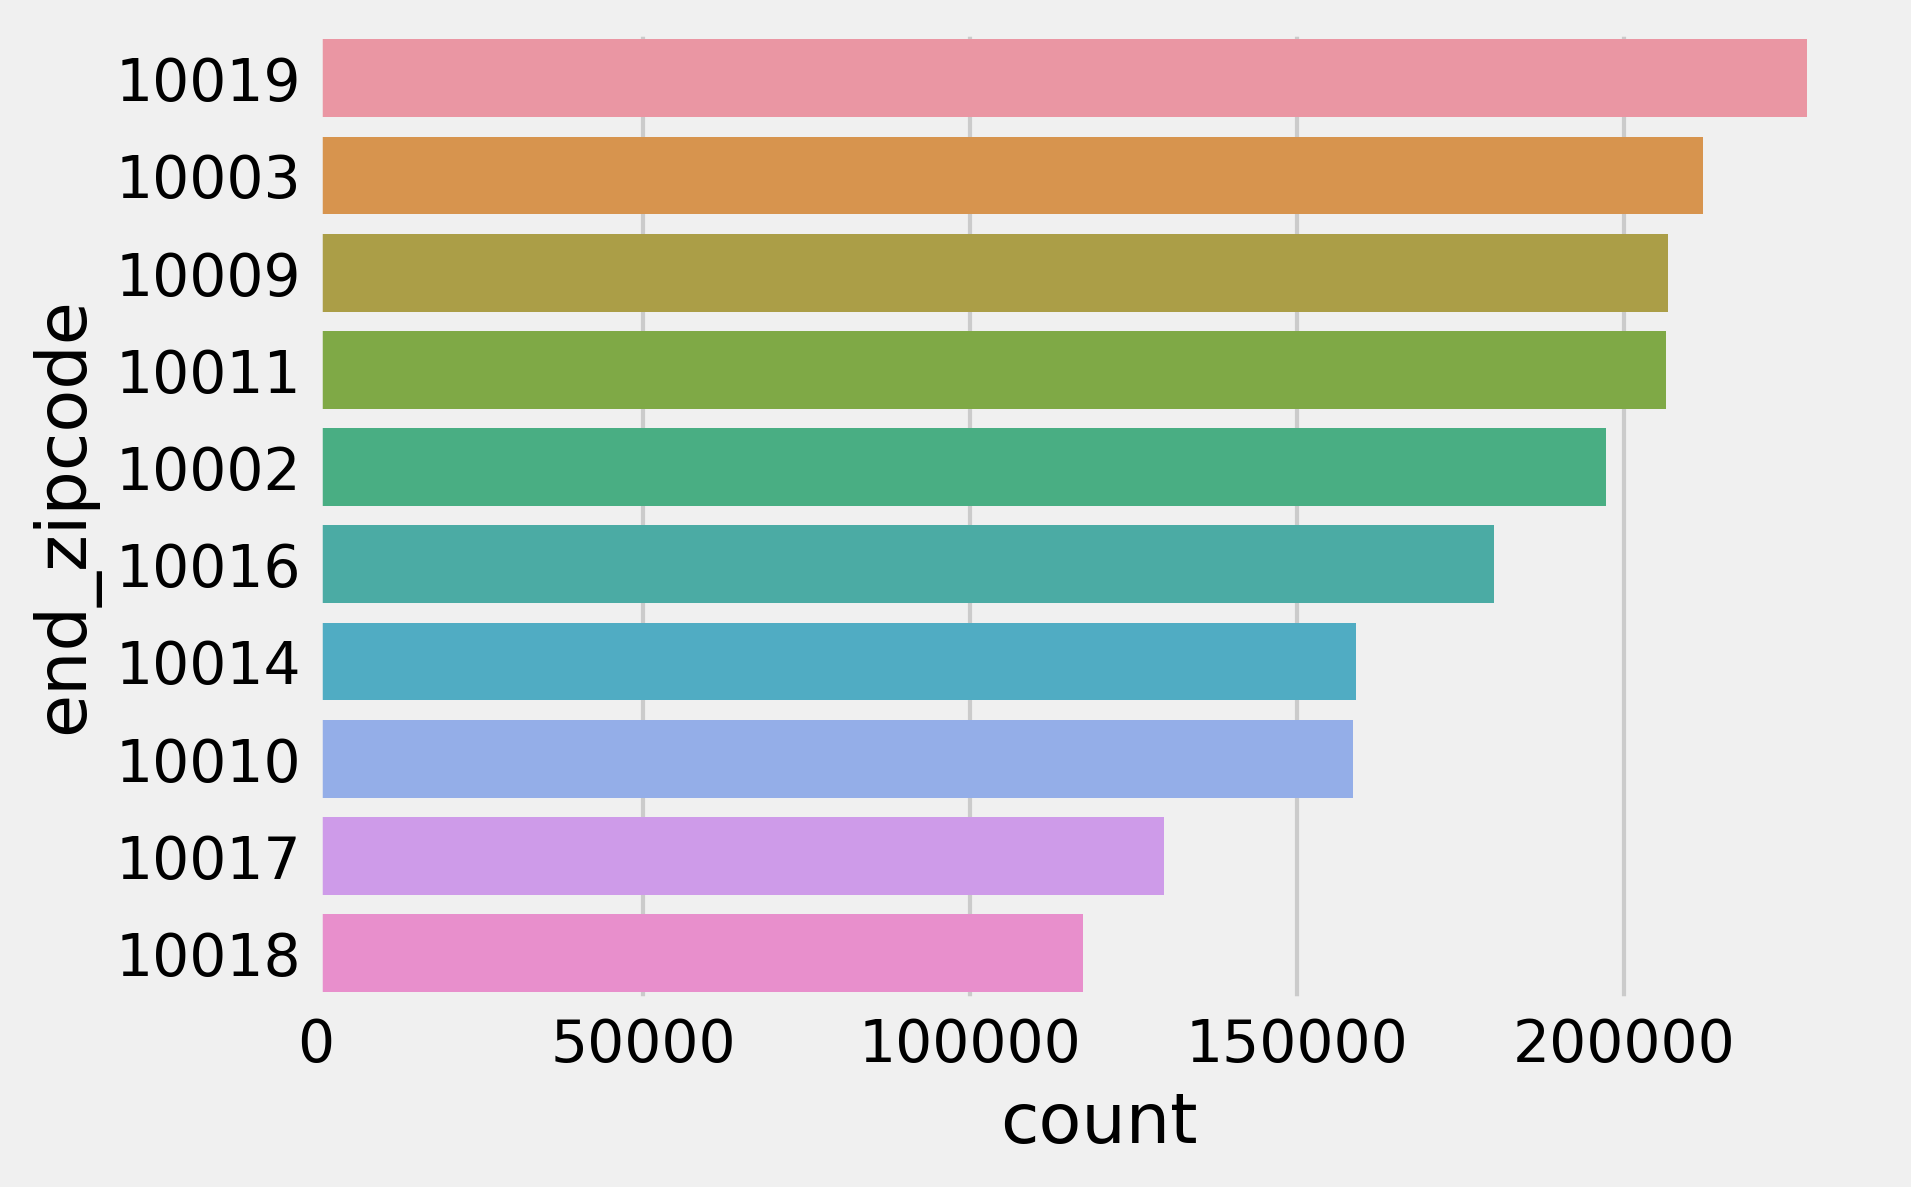

In [25]:
pre_noon = citi[citi['Start Time'].dt.hour<12]
g = sns.countplot(y="end_zipcode", 
                  data=pre_noon,
                  order = pre_noon['end_zipcode'].value_counts().iloc[:10].index)




In [24]:
pre_noon = citi[citi['Start Time'].dt.hour<12]

thing = pre_noon['end_zipcode'].value_counts().iloc[:10].reset_index()
new_thing2 = nyc_zip_df.merge(thing, right_on='index' ,left_on='ZIPCODE')

color = ['#fff100',
         '#ff8c00',
         '#e81123',
         '#ec008c',
         '#68217a',
         '#00188f',
         '#00bcf2',
         '#00b294',
         '#009e49',
         '#bad80a']  
zips_code = list(pre_noon['end_zipcode'].value_counts().iloc[:10].index)
color_mapping = dict(zip(zips_code,color))


# new_thing2.plot(color=new_thing2["ZIPCODE"].map(color_mapping))
fig,axs = plt.subplots(2,figsize = (30, 30))

zip_boundry_map = nyc_zip_df.boundary.plot(color='Black', linewidth=.5,ax=axs[1])
new_thing2.plot(color=new_thing2["ZIPCODE"].map(color_mapping),ax=zip_boundry_map)
# gstart_stations.plot(color='red', markersize = 10,ax=zip_boundry_map)
# zip_boundry_map.axis('off')


minx, miny, maxx, maxy = new_thing2.total_bounds
axs[1].set_xlim(minx, maxx)
axs[1].set_ylim(miny, maxy)

g = sns.countplot(y="end_zipcode", 
                  data=pre_noon,
                  order = pre_noon['end_zipcode'].value_counts().iloc[:10].index,
                  palette=color,
                  ax=axs[0]
                  )




In [26]:
pre_noon = citi[citi['Start Time'].dt.hour<12]

thing = pre_noon['start_zipcode'].value_counts().iloc[:10].reset_index()
new_thing2 = nyc_zip_df.merge(thing, right_on='index' ,left_on='ZIPCODE')

color = ['#fff100',
         '#ff8c00',
         '#e81123',
         '#ec008c',
         '#68217a',
         '#00188f',
         '#00bcf2',
         '#00b294',
         '#009e49',
         '#bad80a']  
zips_code = list(pre_noon['start_zipcode'].value_counts().iloc[:10].index)
color_mapping = dict(zip(zips_code,color))


# new_thing2.plot(color=new_thing2["ZIPCODE"].map(color_mapping))
fig,axs = plt.subplots(2,figsize = (30, 30))

zip_boundry_map = nyc_zip_df.boundary.plot(color='Black', linewidth=.5,ax=axs[1])
new_thing2.plot(color=new_thing2["ZIPCODE"].map(color_mapping),ax=zip_boundry_map)
# gstart_stations.plot(color='red', markersize = 10,ax=zip_boundry_map)
# zip_boundry_map.axis('off')


minx, miny, maxx, maxy = new_thing2.total_bounds
axs[1].set_xlim(minx, maxx)
axs[1].set_ylim(miny, maxy)

g = sns.countplot(y="start_zipcode", 
                  data=pre_noon,
                  order = pre_noon['start_zipcode'].value_counts().iloc[:10].index,
                  palette=color,
                  ax=axs[0]
                  )




In [27]:
nyc_zip_df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich